In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread

%matplotlib inline

In [5]:
checkpoint = '/n/projects/cjw/Data/sez/Checkpoints/2019-03-12-ft/dnet_cat_checkpoint-2500'
#checkpoint = '/ssd1/cjw/Data/sez/Checkpoints/2019-03-07-ft/dnet_cat_checkpoint-2500'
cpmeta = checkpoint + '.meta'

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /n/projects/cjw/Data/sez/Checkpoints/2019-03-12-ft/dnet_cat_checkpoint-2500


In [ ]:
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    try:
        print(op.name, op.outputs, len(op.outputs))
    except:
        print(op.name, "no output")
    print('------')

In [8]:
decoder = sess.graph.get_tensor_by_name('decoder-softmax:0')
images = sess.graph.get_tensor_by_name('Placeholder:0')

In [37]:
''' location of new images'''
import os

folder = '/n/core/micro/sez/jlh/SharedData/Strain 2. Picture 2/'
file = 'Strain 2. Picture 2.tif'
os.path.exists(folder), os.path.exists(folder + file)

(True, True)

(8115, 8131, 3) (1, 1, 3) (1, 1, 3)


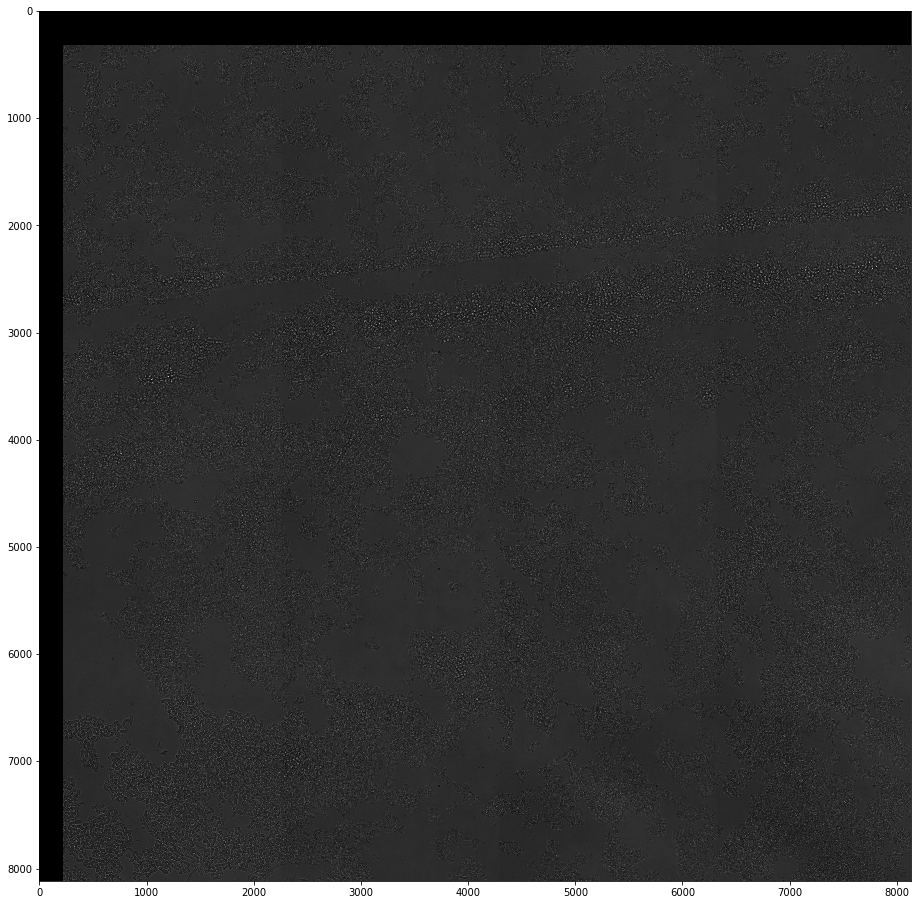

In [38]:
data_raw = imread(folder + file) #'/ssd1/cjw/Data/sez/pombeXkambucha-79.tif')
# data_raw = imread('/ssd1/cjw/Data/sez/pombeXkambucha-3.tif')
data_raw = data_raw[:,:,:]
# data_raw = np.expand_dims(data_raw, -1)
dmin = data_raw.min(axis=(0,1),keepdims=True)
dmax = data_raw.max(axis=(0,1),keepdims=True)
#data = (data_raw - dmin)/(dmax - dmin)

ymean = data_raw.mean(axis=(0,1), keepdims=True)
ystd = data_raw.std(axis=(0,1), keepdims=True)
#test_tif = (test_tif - ymin)/(ymax - ymin + 0.00001)
data = (data_raw - ymean)/ystd

plt.figure(figsize=(16,16))
plt.imshow(data[:,:,2], cmap='gray')
print(data_raw.shape, dmin.shape, dmax.shape)

In [39]:
def decode(patches):
    ds = sess.run(decoder, feed_dict={images:patches})
    return ds

        
def image_to_patches(image, w):
    
    ny, nx, nc = image.shape
    
    patch_list = list()
    xmax = 0
    ymax = 0
    xok = True
    yok = True
    while xok:
        yok = True
        ymax = 0
        xs = xmax
        xmax += w
        if xmax >= nx:
            xmax = nx
            xs = nx - w
            xok = False
        while yok:
            ys = ymax
            ymax += w
            if ymax > ny:
                ymax = ny
                ys = ny - w
                yok = False
            #print(ys, ymax, yok, xs, xmax, xok)
            p = np.expand_dims(image[ys:ymax, xs:xmax, :], 0)
            patch_list.append(p)
    
    patches = np.concatenate(patch_list, axis=0)
    print(patches.shape)
    return  patches

def patches_to_image(patches, w, nx, ny):
    
    image = np.zeros((ny, nx, patches.shape[-1]), dtype=patches.dtype)
    xmax = 0
    ymax = 0
    xok = True
    yok = True
    patch_index = 0
    while xok:
        ymax = 0
        yok = True
        xs = xmax
        xmax += w
        if xmax >= nx:
            xmax = nx
            xs = nx - w
            xok = False
        while yok:
            ys = ymax
            ymax += w
            if ymax > ny:
                ymax = ny
                ys = ny - w
                yok = False
            
            image[ys:ymax, xs:xmax, :] = patches[patch_index]
            patch_index += 1
            #print(patch_index, ys, ymax, xs, xmax, yok, xok)
    return image

In [40]:
import time

t1 = time.time()
p = image_to_patches(data, 256)
d2 = data[128:, 128:, :]
p2 = image_to_patches(d2, 256)
dp = decode(p)
dp2 = decode(p2)
ndp = dp.shape[0]

print(time.time()  - t1)


(1024, 256, 256, 3)
(1024, 256, 256, 3)
7.552870035171509


In [41]:
t1 = time.time()

# dp[:,0:2,:,:] = 0
# dp[:,:,0:2,:] = 0
# dp[:,-2:-1,:,:] = 0
# dp[:,:,-2:-1,:] = 0

# dp2[:,0:2,:,:] = 0
# dp2[:,:,0:2,:] = 0
# dp2[:,-2:-1,:,:] = 0
# dp2[:,:,-2:-1,:] = 0

r1 = patches_to_image(dp, 256, data.shape[1] , data.shape[0])
r2 = patches_to_image(dp2, 256, data.shape[1] - 128, data.shape[0] - 128)

rr2 = r1*0
rr2[128:, 128:, :] = r2

rstack = np.stack((r1, rr2), axis=0)

r = rstack.max(axis=0)

print(time.time()  - t1)

1.6827211380004883


In [42]:
r.shape

(8115, 8131, 3)

(8115, 8131, 3)


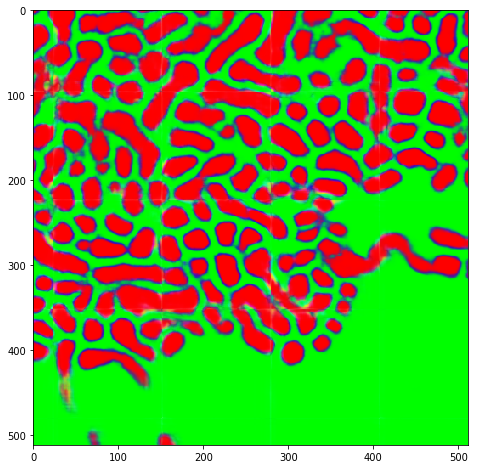

In [43]:
#plt.cla()
tr = r > .5
#tr = tr.astype(np.int32)
#tr = 255*tr
print(tr.shape)
plt.figure(figsize=(8, 8))

plt.imshow(r[4000:4512,1000:1512,:])
plt.show()

In [44]:
import tifffile
savedir = '/n/projects/cjw/Data/sez/Shared/'

try:
    os.makedirs(savedir)
except:
    print("could not make")
    
tifffile.imsave(savedir + file, np.moveaxis(r, -1, 0))

could not make


In [ ]:
xg = 900 + 128
yg = 700

dr = np.expand_dims(data[yg:yg + 256, xg:xg+256,:], 0)
# dr = np.expand_dims(dr, -1)
da = decode(dr)
print(da.shape)
plt.imshow(((0*da[0,:,:,0] + da[0,:,:,1])/1))